### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2025 Semester 2

## Assignment 1

**Student Name:**    `YU LUO`

**Student ID:**     `1528667`

This iPython notebook is a template which you should use for your Assignment 1 submission. This file should be submitted at the **Assignment 1: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a written report explaining your results at the **Assignment 1: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

In [134]:
import numpy as np
import matplotlib.pyplot as plt

# Draw wireframe cube from (x,y) points
def draw_cube(pts):

    # plot points
    plt.figure()
    plt.plot(pts[:, 0], pts[:, 1], 'k.')

    # define edges
    edges = np.array([
        [0, 1], [2, 3], [0, 2], [1, 3],
        [4, 5], [6, 7], [4, 6], [5, 7],
        [0, 4], [1, 5], [2, 6], [3, 7]
    ])

    # plot edges
    for edge in edges:
        plt.plot(pts[edge, 0], pts[edge, 1], 'k-')  # plot lines between connected edges

    # crop to sensor area (24 x 36 mm)
    plt.axis('equal')
    plt.xlim([-18, 18])
    plt.ylim([-12, 12])
    plt.show()

### 1. Mapping between world and image coordinates

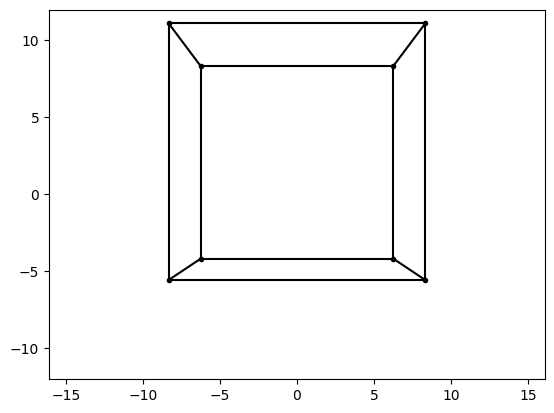

In [135]:
# corners of the cube in the image
xy_image = np.array([[-8.333333, -5.555556],
                     [8.333333, -5.555556],
                     [-8.333333, 11.11111],
                     [8.333333, 11.11111],
                     [-6.25, -4.166667],
                     [6.25, -4.166667],
                     [-6.25, 8.333333],
                     [6.25, 8.333333]])

# draw the cube
draw_cube(xy_image)

#### 1.1 Compute the world coordinates

In [136]:

# Camera / scene parameters (mm)
f = 50.0
Z_front = 900.0
s = 300.0
Z_back = Z_front + s

# According to the setup, first 4 are the front face, last 4 are the back face
Z = np.array([Z_front]*4 + [Z_back]*4, dtype=float)

# Vectorised inverse projection: X = x*Z/f, Y = y*Z/f
X = xy_image[:, 0] * Z / f # Recover all the X_World coordinates
Y = xy_image[:, 1] * Z / f # Recover all the Y_World coordinates

# Stack all individual coordinates back to 3D format
coords_world = np.column_stack([X, Y, Z])

# Labels matching the corner order:
corner_labels = [
    "F_BL", "F_BR", "F_TL", "F_TR",
    "B_BL", "B_BR", "B_TL", "B_TR"
]

# Print out all corners coordinates in a table
print(f"{'Corner':<6} | {'X (mm)':>8} {'Y (mm)':>9} {'Z (mm)':>9}")
print("-"*40)
for lbl, (xw, yw, zw) in zip(corner_labels, coords_world):
    print(f"{lbl:<6} | {xw:8.0f} {yw:9.0f} {zw:9.0f}")


Corner |   X (mm)    Y (mm)    Z (mm)
----------------------------------------
F_BL   |     -150      -100       900
F_BR   |      150      -100       900
F_TL   |     -150       200       900
F_TR   |      150       200       900
B_BL   |     -150      -100      1200
B_BR   |      150      -100      1200
B_TL   |     -150       200      1200
B_TR   |      150       200      1200


#### 1.2 Write code to convert world coordinates to image coordinates and translate the cube in the world

##### 1.2.1 Convert world coordinates

In [137]:

# -------------------------------
# Camera / scene parameters (mm)
# -------------------------------
f = 50.0               # focal length (mm)
Z_front = 900.0        # Z of the front face (mm)
side = 300.0           # cube side length (mm)
Z_back  = Z_front + side

# ----------------------------------------------------
# 1) Retrieve the cube in WORLD coordinates from our calculation
# ----------------------------------------------------
# Order: F_BL, F_BR, F_TL, F_TR, B_BL, B_BR, B_TL, B_TR (8x3)
cube_world = coords_world

# ----------------------------------------------------
#    World -> Image (pinhole)
#    Input: Pw (...,3) in mm, camera at origin, looking +Z
#    Output: pi (...,2) image coords (mm)
#    Formula: x = f * X/Z,  y = f * Y/Z
# ----------------------------------------------------
def world_to_image(Pw, f_mm):
    """
    Vectorised pinhole projection from world (mm) to image plane (mm).

    Projects 3D world coordinates (X, Y, Z) onto the 2D image plane (x, y)
    using the pinhole camera model. The camera is assumed to be at the
    origin (0, 0, 0) looking along the positive Z-axis.

    Parameters
    ----------
    Pw : ndarray (..., 3)
        World coordinates [X, Y, Z] in millimetres.
        Can be a single point (3,) or multiple points (N, 3), etc.
    f_mm : float
        Focal length of the camera in millimetres.

    Returns
    -------
    pi : ndarray (..., 2)
        Image coordinates [x, y] in millimetres.
        The shape matches the input Pw, but with the last dimension
        reduced from 3 to 2.
    """
    # Extract X, Y, and Z coordinates from the input array
    X = Pw[..., 0]
    Y = Pw[..., 1]
    Z = Pw[..., 2]


    # Prevent division by zero or projection of points behind the camera (Z <= 0)

    # Solution: Replacing Z values less than or equal to a small epsilon with epsilon
    # if it is at the camera (Z=0) or even behind the camera (Z<0)
    # to avoid errors and push points very far away
    eps = 1e-9
    Z_safe = np.maximum(Z, eps) # In our setup, it will always choose the normal Z as it is positive

    # Apply the pinhole projection formula: x = f * X / Z and y = f * Y / Z
    x = f_mm * X / Z_safe
    y = f_mm * Y / Z_safe

    # Stack the resulting x and y coordinates to form the 2D image points
    return np.stack([x, y], axis=-1)


In [138]:
# Convert to image plane using our calcualted world coordinates
xy_image_new = world_to_image(cube_world, f)

print(f"{'Corner':<6} | {'x (mm)':>10} {'y (mm)':>10}")
print("-"*40)
for lbl, (xw, yw) in zip(corner_labels, xy_image_new):
    print(f"{lbl:<6} | {xw:10.6f} {yw:10.6f}")

Corner |     x (mm)     y (mm)
----------------------------------------
F_BL   |  -8.333333  -5.555556
F_BR   |   8.333333  -5.555556
F_TL   |  -8.333333  11.111110
F_TR   |   8.333333  11.111110
B_BL   |  -6.250000  -4.166667
B_BR   |   6.250000  -4.166667
B_TL   |  -6.250000   8.333333
B_TR   |   6.250000   8.333333


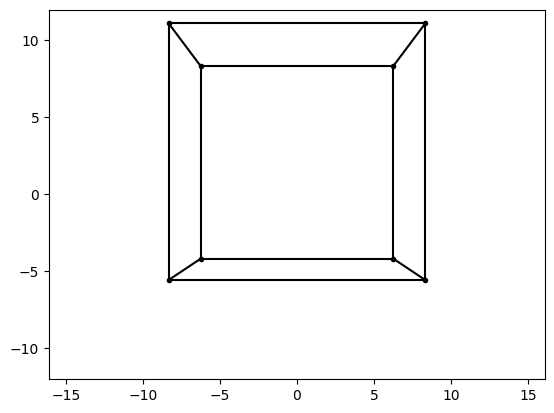

In [139]:
draw_cube(xy_image_new) # Shows the cube using the converted coordinates to see if it matches original

##### 1.2.2 Translate the cube in the world

In [140]:
def translate_world(Pw, t):
    """
    Translate world coordinates by a 3D vector t (mm).

    Adds a constant translation vector `t` to each 3D point in `Pw`.

    Parameters
    ----------
    Pw : ndarray (N, 3)
        World coordinates. Can be a single point or multiple points.
    t  : array-like (3,)
        Translation vector [dX, dY, dZ] in mm.

    Returns
    -------
    Pw_translated : ndarray (N, 3)
        Translated world coordinates.
    """
    # Ensure the translation vector is a numpy array and has the correct shape
    t = np.asarray(t, dtype=float).reshape(1, 3)
    # Add the translation vector to the world coordinates
    return Pw + t

##### 1.2.3 Verify the translation

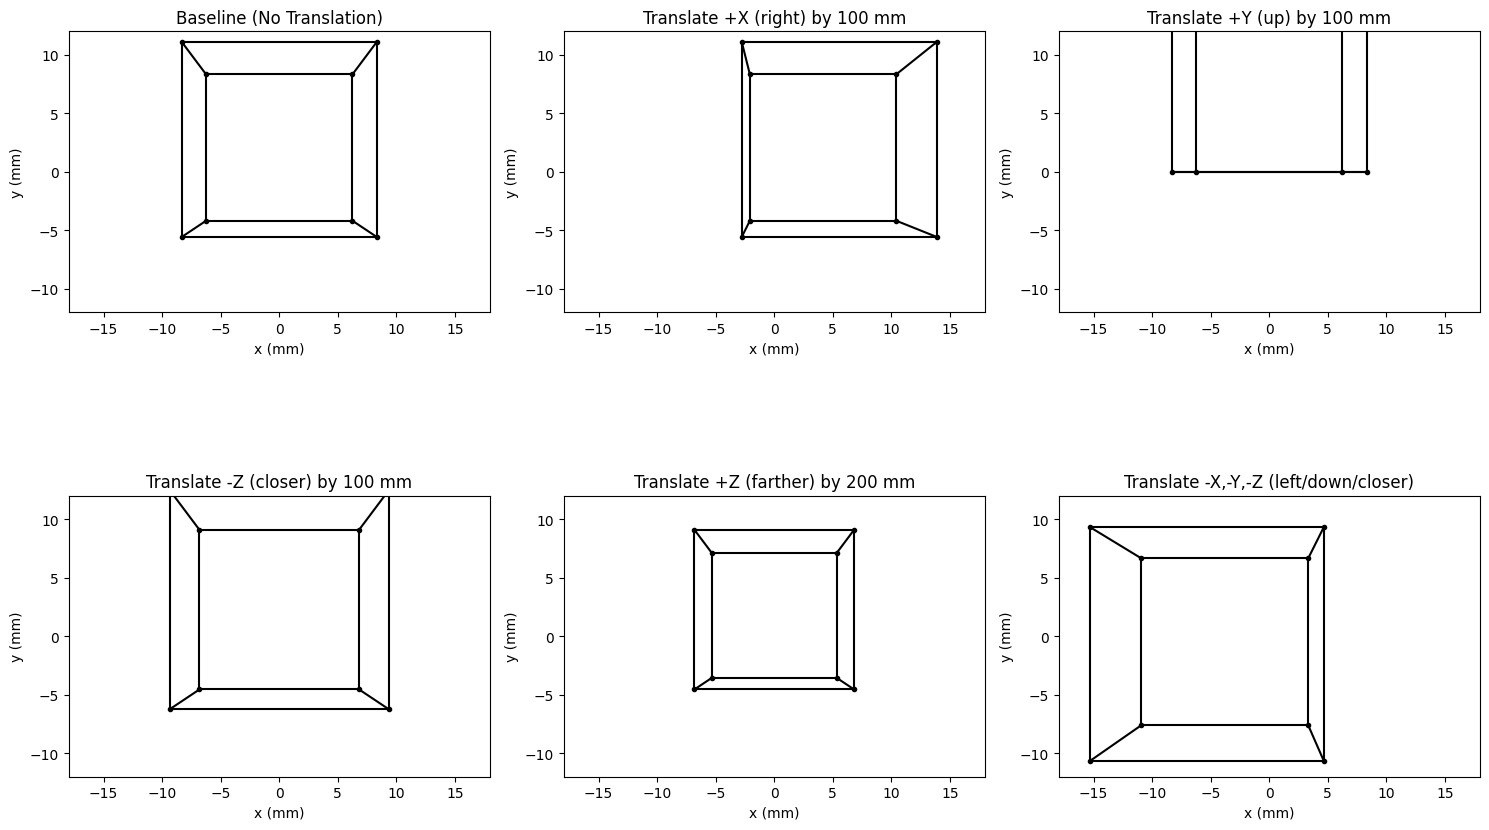

In [141]:
# New helper function to display cube in the image plane on specific plt axes
def draw_cube_subplot(ax, pts):
    """
    Draw a wireframe cube on a specific matplotlib Axes object.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes to draw the cube on.
    pts : ndarray (8, 2)
        The 2D image coordinates of the cube's vertices.
    """
    # plot points
    ax.plot(pts[:, 0], pts[:, 1], 'k.')

    # define edges
    edges = np.array([
        [0, 1], [2, 3], [0, 2], [1, 3],
        [4, 5], [6, 7], [4, 6], [5, 7],
        [0, 4], [1, 5], [2, 6], [3, 7]
    ])

    # plot edges
    for edge in edges:
        ax.plot(pts[edge, 0], pts[edge, 1], 'k-')

    # crop to sensor area (24 x 36 mm)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim([-18, 18])
    ax.set_ylim([-12, 12])
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')


def project_and_draw_cube(ax, Pw, f, title):
    """
    Projects world coordinates to image coordinates and draws the cube on a subplot.
    """
    image_coords = world_to_image(Pw, f)
    draw_cube_subplot(ax, image_coords)
    ax.set_title(title)



# Set up a figure with multiple subplots to show all transformations at once.
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# (a) No translation (baseline)
project_and_draw_cube(axes[0], cube_world, f, "Baseline (No Translation)")

# (b) Move RIGHT by +100 mm in world (X direction) -> image x should shift right
Pw_right = translate_world(cube_world, t=[+100.0, 0.0, 0.0])
project_and_draw_cube(axes[1], Pw_right, f, "Translate +X (right) by 100 mm")

# (c) Move UP by +100 mm in world (Y direction) -> image y should shift up
Pw_up = translate_world(cube_world, t=[0.0, +100.0, 0.0])
project_and_draw_cube(axes[2], Pw_up, f, "Translate +Y (up) by 100 mm")

# (d) Move CLOSER by -100 mm in world (Z direction) -> image should get larger
Pw_closer = translate_world(cube_world, t=[0.0, 0.0, -100.0])
project_and_draw_cube(axes[3], Pw_closer, f, "Translate -Z (closer) by 100 mm")

# (e) Move FARTHER by +200 mm in world (Z direction) -> image should get smaller
Pw_farther = translate_world(cube_world, t=[0.0, 0.0, +200.0])
project_and_draw_cube(axes[4], Pw_farther, f, "Translate +Z (farther) by 200 mm")

# (f) A combined translation (left, down, closer)
Pw_combo = translate_world(cube_world, t=[-80.0, -60.0, -150.0])
project_and_draw_cube(axes[5], Pw_combo, f, "Translate -X,-Y,-Z (left/down/closer)")

plt.tight_layout()
plt.show()

### 2. Depth of field simulation

Make sure to upload the image zip folder to the `/content` directory and use following command to unzip it.

In [142]:
!unzip /content/COMP90086_asst1_2025_images.zip

Archive:  /content/COMP90086_asst1_2025_images.zip
replace OldQuad.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: OldQuad.jpg             
replace OldQuad-depth.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: OldQuad-depth.png       
replace OWeek.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: OWeek.jpg               
replace OWeek-depth.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: OWeek-depth.png         


In [143]:
# Example image
img = 'OWeek.jpg'
z_world = 'OWeek-depth.png' # Z_world in mm
f = 28 # focal length in mm

# Example image
img = 'OldQuad.jpg'
z_world = 'OldQuad-depth.png' # Z_world in mm
f = 24 # focal length in mm

# sensor width/height in mm
h_sensor = 24
w_sensor = 36

#### 2.1 DOF Implementation

In [144]:
import cv2

def simulate_depth_of_field(
    img_path: str,
    depth_map_path: str,
    f_mm: float,
    h_sensor_mm: float,
    w_sensor_mm: float,
    focal_plane_z_mm: float,
    focus_band_mm: float, # represents the distance threshold of the focus area
    blur_kernel: int = 15 # odd Gaussian kernel size
):
    """
    Simulate low depth of field with a SINGLE global Gaussian blur and a HARD in-focus mask.

    """
    # 1) Load image (RGB) and depth (mm)
    img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    depth = cv2.imread(depth_map_path, cv2.IMREAD_ANYDEPTH)
    if depth is None:
        raise FileNotFoundError(f"Depth map not found: {depth_map_path}")
    depth = depth.astype(np.float32)

    # Retrieve the image width and height
    H, W = img.shape[:2]

    # invalid / non-positive depths -> NaN (won’t be considered in focus)
    depth[~np.isfinite(depth)] = np.nan
    depth[depth <= 0] = np.nan

    # 2) Build sensor coordinate grid in mm (origin at optical point)
    x_mm = np.linspace(-w_sensor_mm/2, +w_sensor_mm/2, W, dtype=np.float32)
    y_mm = np.linspace(-h_sensor_mm/2, +h_sensor_mm/2, H, dtype=np.float32)

    # Construct a 2D coordinate system for the camera sensor, in millimeters
    x_grid, y_grid = np.meshgrid(x_mm, y_mm)  # (H,W)

    # 3) Reconstruct world (X,Y,Z) to calculate distance to camera centre
    X = (x_grid * depth) / f_mm
    Y = (y_grid * depth) / f_mm
    Z = depth

    # get actual distance towards the camera centre for each coordinate (X, Y, Z)
    d = np.sqrt(X*X + Y*Y + Z*Z)


    # Distance to focal plane point on optical axis (0,0,Zf)
    d_focus = float(np.sqrt(focal_plane_z_mm**2))

    # 4) HARD in-focus mask: |d - d_focus| <= focus_band_mm
    in_focus_mask = np.abs(d - d_focus) <= focus_band_mm
    in_focus_mask &= np.isfinite(depth)  # exclude invalid Z

    # 5) Global blur + composite
    k = int(blur_kernel) | 1  # force odd with bitwise OR operation
    k = max(3, k)
    blurred = cv2.GaussianBlur(img, (k, k), 0)

    # Composite by replacing those in-focus pixel with unblurred value
    result = blurred.copy()
    result[in_focus_mask] = img[in_focus_mask]

    return result, in_focus_mask, d


In [145]:
# O-Week
res_oweek, mask_oweek, d1 = simulate_depth_of_field(
    "OWeek.jpg", "OWeek-depth.png",
    f_mm=28.0, h_sensor_mm=24.0, w_sensor_mm=36.0,
    focal_plane_z_mm=500.0,
    focus_band_mm=100.0,
    blur_kernel=51
)

# Old Quad
res_old, mask_old, d2 = simulate_depth_of_field(
    "OldQuad.jpg", "OldQuad-depth.png",
    f_mm=24.0, h_sensor_mm=24.0, w_sensor_mm=36.0,
    focal_plane_z_mm=1000.0,
    focus_band_mm=100.0,
    blur_kernel=51
)


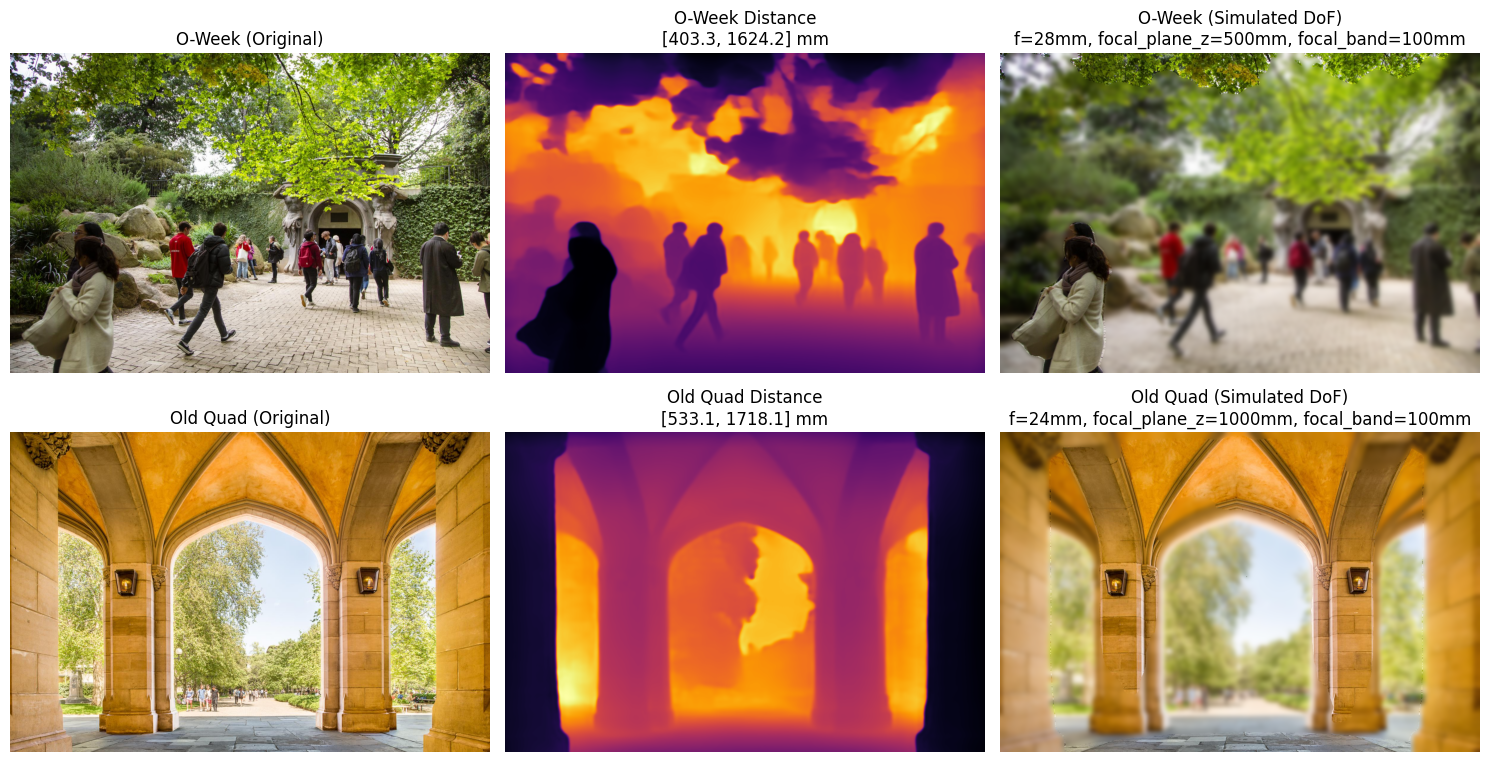

In [146]:
# Create side-by-side comparison: each row = one scene
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# O-Week
axes[0, 0].imshow(plt.imread("OWeek.jpg"))
axes[0, 0].set_title("O-Week (Original)")
axes[0, 0].axis("off")

im1 = axes[0, 1].imshow(d1, cmap="inferno")  # depth map
axes[0, 1].set_title(f"O-Week Distance\n[{d1.min():.1f}, {d1.max():.1f}] mm")
axes[0, 1].axis("off")

axes[0, 2].imshow(res_oweek)
axes[0, 2].set_title("O-Week (Simulated DoF)\nf=28mm, focal_plane_z=500mm, focal_band=100mm")
axes[0, 2].axis("off")

# Old Quad
axes[1, 0].imshow(plt.imread("OldQuad.jpg"))
axes[1, 0].set_title("Old Quad (Original)")
axes[1, 0].axis("off")

im2 = axes[1, 1].imshow(d2, cmap="inferno")  # depth map
axes[1, 1].set_title(f"Old Quad Distance\n[{d2.min():.1f}, {d2.max():.1f}] mm")
axes[1, 1].axis("off")

axes[1, 2].imshow(res_old)
axes[1, 2].set_title("Old Quad (Simulated DoF)\nf=24mm, focal_plane_z=1000mm, focal_band=100mm")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()


#### 2.2 Discussion & Experiement

In [147]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Helper function to generate side-by-side comparison using different paramters
def run_and_plot_scenario(
    title,
    f_oweek, f_old,
    Zf_oweek, Zf_old,
    band_oweek, band_old,
    kernel_oweek, kernel_old
):
    # --- O-Week ---
    res_oweek, mask_oweek, d1 = simulate_depth_of_field(
        "OWeek.jpg", "OWeek-depth.png",
        f_mm=f_oweek, h_sensor_mm=24.0, w_sensor_mm=36.0,
        focal_plane_z_mm=Zf_oweek,
        focus_band_mm=band_oweek,
        blur_kernel=kernel_oweek
    )
    orig_oweek = plt.imread("OWeek.jpg")

    # --- Old Quad ---
    res_old, mask_old, d2 = simulate_depth_of_field(
        "OldQuad.jpg", "OldQuad-depth.png",
        f_mm=f_old, h_sensor_mm=24.0, w_sensor_mm=36.0,
        focal_plane_z_mm=Zf_old,
        focus_band_mm=band_old,
        blur_kernel=kernel_old
    )
    orig_old = plt.imread("OldQuad.jpg")

    # --- Plot: Original | Depth | Result (no numeric values on depth)
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    fig.suptitle(title, fontsize=14)

    # Row 1 – O-Week
    axes[0,0].imshow(orig_oweek);           axes[0,0].set_title("O-Week (Original)");  axes[0,0].axis("off")
    axes[0,1].imshow(res_oweek);            axes[0,1].set_title("O-Week (DoF)");       axes[0,1].axis("off")

    # Row 2 – Old Quad
    axes[1,0].imshow(orig_old);             axes[1,0].set_title("Old Quad (Original)");axes[1,0].axis("off")
    axes[1,1].imshow(res_old);              axes[1,1].set_title("Old Quad (DoF)");      axes[1,1].axis("off")

    plt.tight_layout()
    plt.show()


##### Scenario A

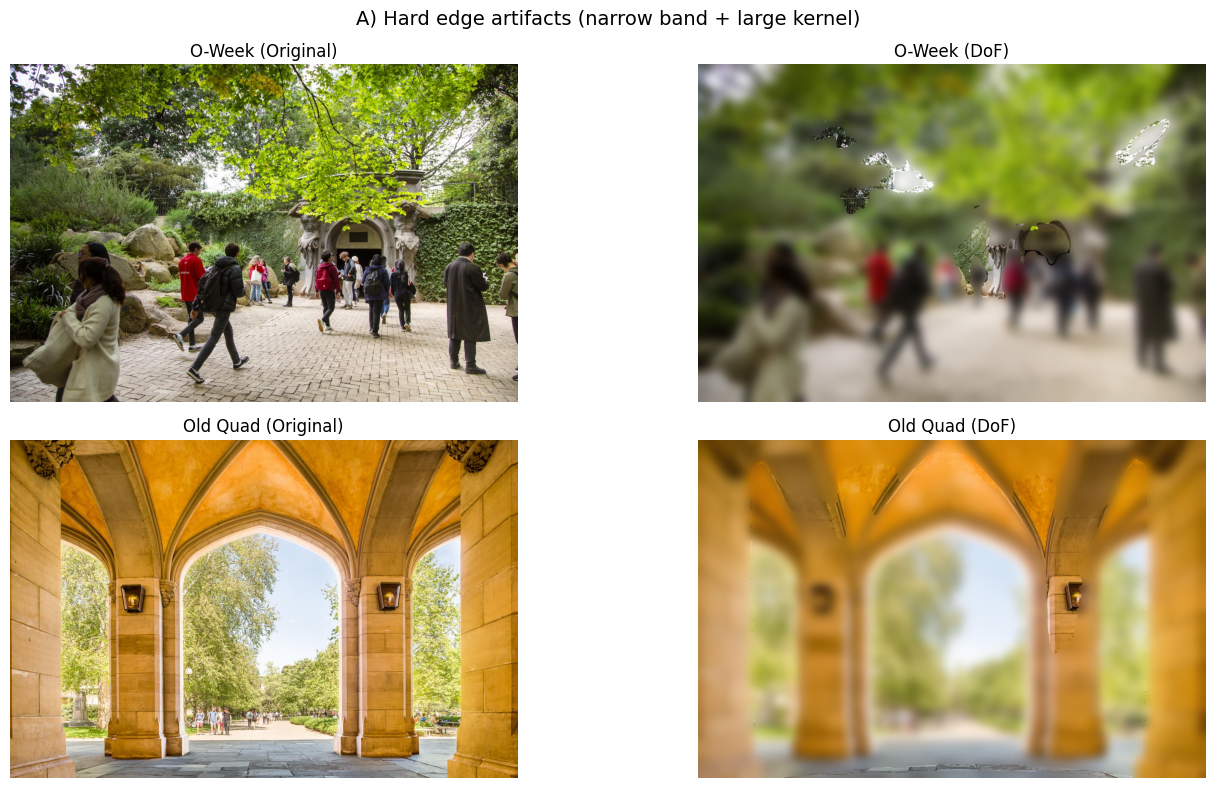

In [148]:
run_and_plot_scenario(
    title="A) Hard edge artifacts (narrow band + large kernel)",
    f_oweek=28.0, f_old=24.0,
    Zf_oweek=1500.0,  Zf_old=1000.0,
    band_oweek=50.0,  band_old=25.0,     # very narrow band
    kernel_oweek=101, kernel_old=101     # strong blur to make artifacts obvious
)

##### Scenario B

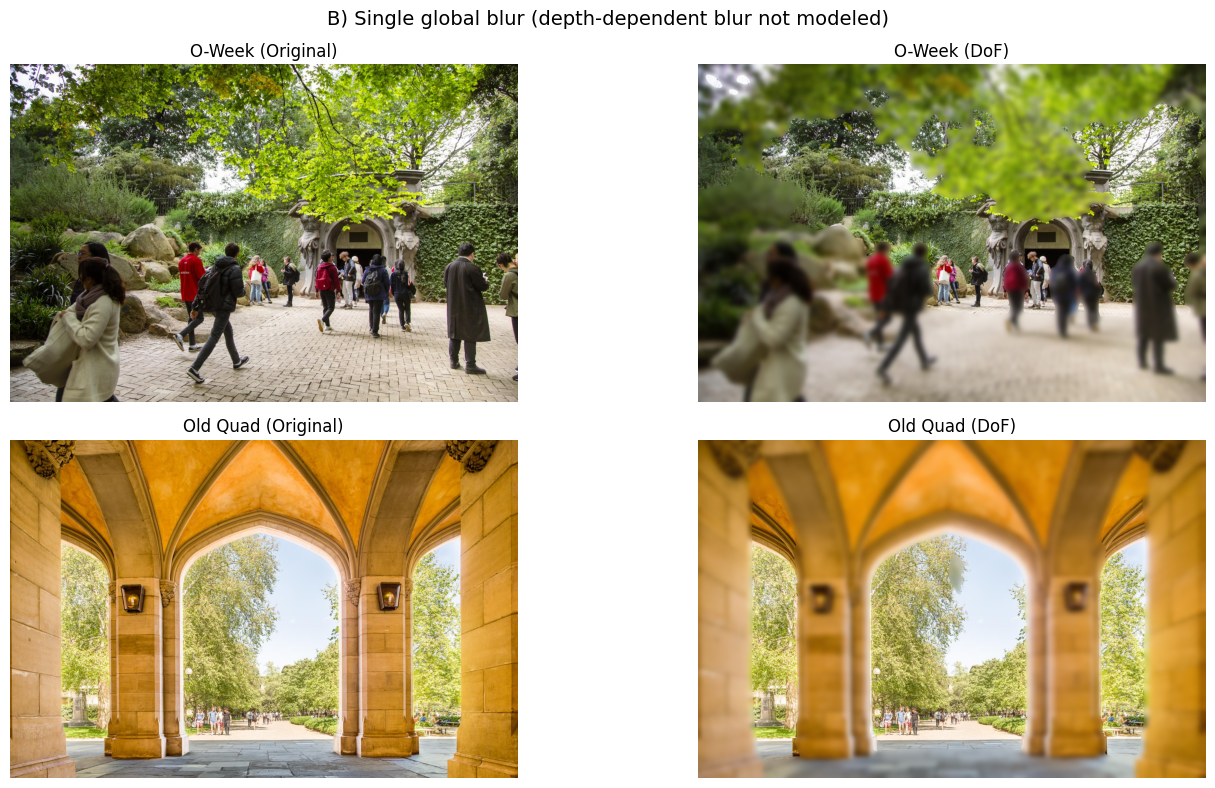

In [149]:
run_and_plot_scenario(
    title="B) Single global blur (depth-dependent blur not modeled)",
    f_oweek=28.0, f_old=24.0,
    Zf_oweek=1500.0,  Zf_old=1500.0,     # same focus depth
    band_oweek=300.0, band_old=300.0,    # moderate band
    kernel_oweek=51,  kernel_old=51      # one kernel for everything
)

##### Scenario C

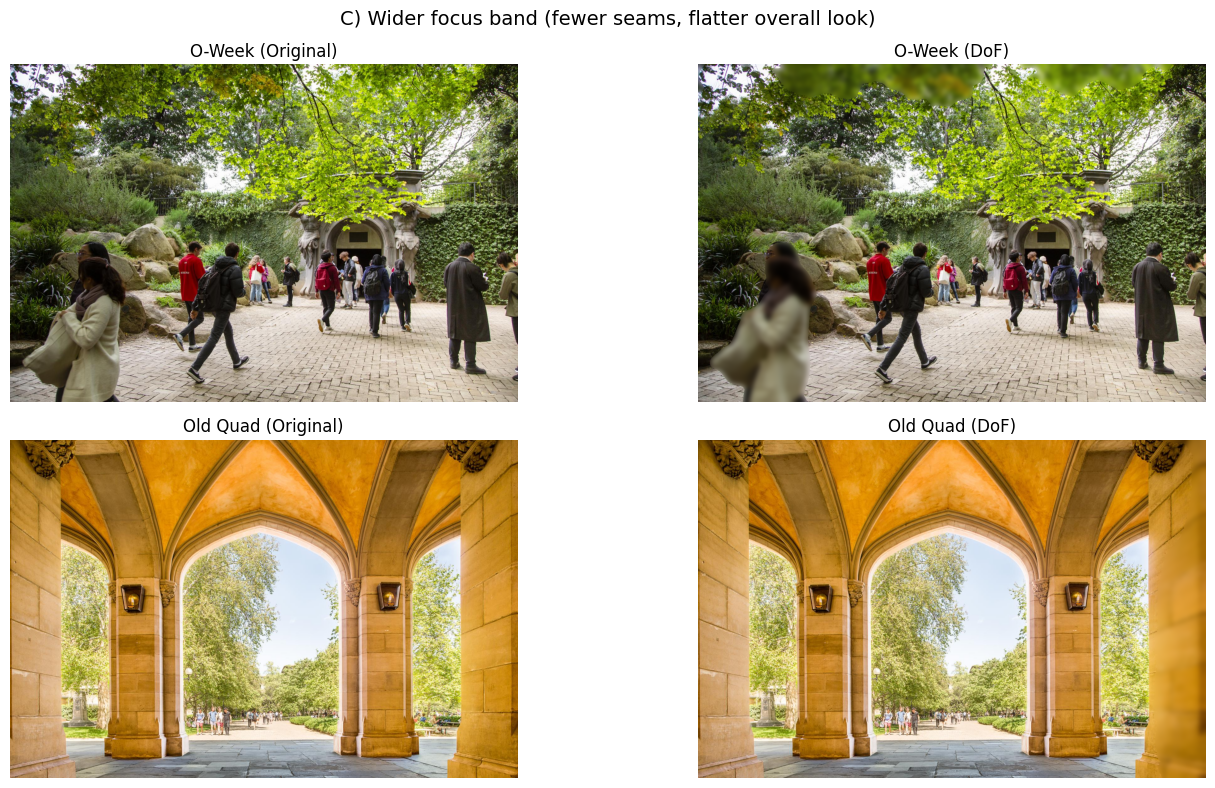

In [150]:
run_and_plot_scenario(
    title="C) Wider focus band (fewer seams, flatter overall look)",
    f_oweek=28.0, f_old=24.0,
    Zf_oweek=1500.0,  Zf_old=1500.0,
    band_oweek=900.0, band_old=900.0,    # very wide band
    kernel_oweek=51,  kernel_old=51
)